In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors


import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import *
from package_LAB import *

simulation params

In [1]:
#wrong 
#SOPDT PV in-out dynamics params
Kp = 0.46575892823243076
T1p = 132.04151002516983
T2p = 7.647730018039972
thetap = 0.0004910330468864688

#SOPDT DV disturbance dynamics params
Kd = 1.7443694961231686
T1d = 175.24005491030132
T2d = 105.33387389061804
thetad = 7.000129805865814

In [2]:
#SOPDT PV in-out dynamics params
Kp = 0.6738137025155853
T1p = 183.44770757727215
T2p = 5.327855225788805e-05
thetap = 10.192078303908199

#SOPDT DV disturbance dynamics params
Kd = 1.7443694961231686
T1d = 175.24005491030132
T2d = 105.33387389061804
thetad = 7.000129805865814

In [5]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 2 
Kc,Ti,Td = IMC_tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

alpha = 1
MVMin = 0
MVMax = 100

In [6]:

# # OLP + no FF
# ManPath = {0: True, TSim: True}               # Path for Man
# MVManPath = {0: MV0 , Tsim : MV0}             # path for MVMan
# SPPath = {0: PV0, TSim: MV0}                  # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60, TSim: 60.0}      # Path for DV
# ActivateFF = False
# ManFF = True

             
# ManPath = {0: True, TSim: True}               # Path for Man
# MVManPath = {0: MV0, TSim: MV0}               # Path for MVMan
# SPPath = {0: PV0, TSim: PV0}                  # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60,  TSim: 60.0}     # Path for DV
# ActivateFF = True
# ManFF = True

          
# FF + CLP
ManPath = {0: True, 750: False,  TSim: False}   # Path for Man
MVManPath = {0: MV0, TSim: MV0}                 # Path for MVMan
SPPath = {0: PV0,800:PV0-10, TSim: PV0-10}      # Path for SP, always the same in most cases
DVPath = {0: DV0,1500: DV0+10, TSim: DV0+10}    # Path for DV
ActivateFF = True
ManFF= False

# ManPath = {0:True, 750: False, TSim: False}   # Path for Man
# MVManPath = {0: MV0, TSim: MV0}               # Path for MVMan
# SPPath = {0: PV0, 800:PV0-10, TSim: PV0-10}   # Path for SP, always the same in most cases
# DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
# ActivateFF = False
# ManFF= False


(0.0, 2200.0)

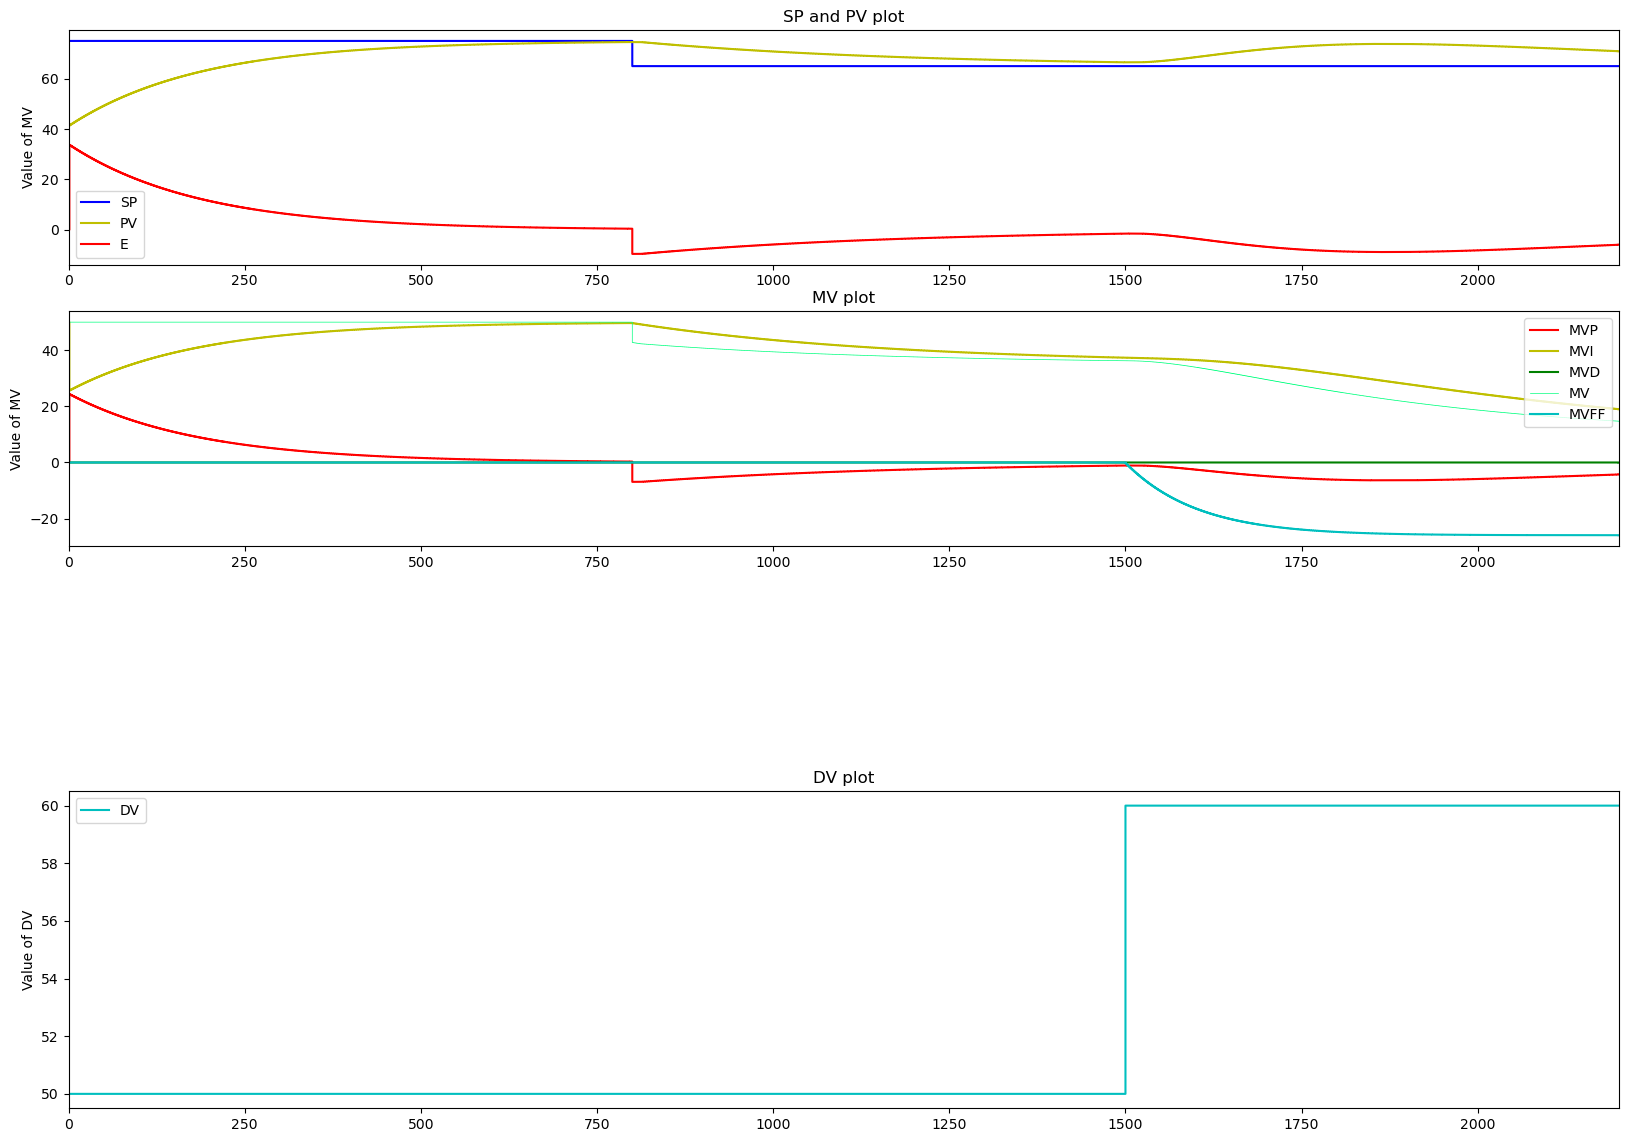

In [7]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []

MVFF = []
MVMan=[]
Man = []

MVFFDelay = []
MVFFLL = []

MVDelayp = []
MVDelayd = []

PV1p = []   #use in case of FF activation
PV2p = []

PV1d = []
PV2d = []


for i in range(0,N):
    t.append(i*Ts)
    
    # sp & dv
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    Lead_Lag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    Lead_Lag_RT(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    # PID mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # pid
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)

    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0) # ajout de cette ligne car sys non linéeiare -> risque instabilité coté Z négatif
    
    
plt.figure(figsize = (20,14))

plt.subplot(4,1,1)
plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,PV,'y-',label='PV',where='post')
plt.step(t,E,'r-',label='E',where='post')
plt.ylabel('Value of MV')
plt.title('SP and PV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,MVP,'r-',label='MVP',where='post')
plt.step(t,MVI,'y-',label='MVI',where='post')
plt.step(t,MVD,'g-',label='MVD',where='post')
plt.step(t,MV,'springgreen',linewidth=0.5,label='MV',where='post')
plt.step(t,MVFF,'c-',label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.title('MV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])

# plt.subplot(4,1,3)
# plt.step(t,E,'r-',label='E',where='post')
# plt.ylabel('Value of MV')
# plt.title('Error plot')
# plt.legend(loc='best')
# plt.xlim([0, TSim])

plt.subplot(3,1,3)
plt.step(t,DV,'c-',label='DV',where='post')
plt.ylabel('Value of DV')
plt.title('DV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])